### Introduction to Data Science
### Assignment Number 6
#### Professors: Bahrak & Yaghoob Zadeh
#### Mohamad Mahdi Samadi (810101465)

In [45]:
import pandas as pd
import csv
import numpy as np
import random
import matplotlib.pyplot as plt

from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.ensemble import IsolationForest

In [ ]:
df = pd.read_csv("./dataset_diabetes/diabetic_data.csv")

<a id="preprocess"></a>
## Preprocessing

<a id="missing values"></a>
### Dealing with missing values

I noticed that most of the missing values are labeled as *?* and the rest of them are *NaN* as expected. 

In [2]:
df.replace('?', None, inplace=True)
desc = pd.DataFrame()
desc["Null Count"] = df.isnull().sum()
desc["Null Perc"] = (100 * desc["Null Count"] / len(df)).round(2)
display(desc[desc["Null Count"] > 0])

,Null Count,Null Perc
race,2273,2.23
weight,98569,96.86
payer_code,40256,39.56
medical_specialty,49949,49.08
diag_1,21,0.02
diag_2,358,0.35
diag_3,1423,1.40
max_glu_serum,96420,94.75
A1Cresult,84748,83.28


There are features with a high percentage of missing values.
- Important as *weight* is, We can't fill missing values knowing only 3 percent of it.
- *payer code* and *medical specialty* are not important.
- *max glu serum* and *A1C result* are like *weight*

In conclusion we can drop the mentioned columns and have a cleaner dataset.

Now what to do with the remainig missing data?
We are provided with a large dataset and $3.65 \%$ is a small proportion of it. In order to have a better dataset we'll remove them too.

In [3]:
desc = pd.DataFrame(columns=["Dataset Size", "Null Count", "Null Perc"])
    
desc.loc[len(desc.index)] = [len(df), len(df) - len(df.dropna()), round(100 * (len(df) - len(df.dropna())) / len(df), 2)]

df.drop(["weight", "payer_code", "medical_specialty", "max_glu_serum", "A1Cresult"], axis=1, inplace=True)
desc.loc[len(desc.index)] = [len(df), len(df) - len(df.dropna()), round(100 * (len(df) - len(df.dropna())) / len(df), 2)]

df.dropna(inplace=True)
desc.loc[len(desc.index)] = [len(df), len(df) - len(df.dropna()), round(100 * (len(df) - len(df.dropna())) / len(df), 2)]

desc.index = ["Original Dataset", "After removing columns", "After removing rows"]
desc["Dataset Size"] = desc["Dataset Size"].astype(int)
desc["Null Count"] = desc["Null Count"].astype(int)
display(desc)

,Dataset Size,Null Count,Null Perc
Original Dataset,101766,101766,100.00
After removing columns,101766,3713,3.65
After removing rows,98053,0,0.00


<a id="labeling"></a>
### Labeling strings by numbers

1. *Age:* each interval is replaced by the middle of itself.

In [4]:
def find_middle_of_interval(interval):
    start, end = interval[1: -1].split("-")
    return (int(start) + int(end)) // 2

df["age"] = df["age"].apply(lambda x: find_middle_of_interval(x))

2. *Race* and *Gender:* each unique value is labeled by a distinct number.

In [5]:
def get_actual_value_of_mapped_IDs(file_path, cols):
    stoi = {cols[i]: dict() for i in range(len(cols))}
    i = 0
    with open(file_path, mode='r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            if row["description"] == "description": i += 1; continue
            if row["description"] == "": continue
            stoi[cols[i]][int(row['admission_type_id'])] = row['description']
    return stoi

stoi = get_actual_value_of_mapped_IDs(file_path="./dataset_diabetes/IDs_mapping.csv",
        cols=['admission_type_id', 'discharge_disposition_id', 'admission_source_id'])

3. *medication features:* Also labeled by numbers.

In [6]:
def create_hash_dict(df):
    stoi = dict()    
    unique_values = list(df.unique())
    for i in range(len(unique_values)):
        stoi[unique_values[i]] = i
    return stoi

def label_column(df, col):
    stoi[col] = create_hash_dict(df[col])
    df[col] = df[col].apply(lambda x: stoi[col][x])

label_column(df, "race")
label_column(df, "gender")

medication_features = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone',]
for f in medication_features:
    label_column(df, f)

By looking at the values of the medical features, I noticed that a large proportion of them have value of 0 (which were originally "NO"). The describe method helps to gain a better understanding of it. some features contain only binary values and have a significantly low mean. Obviously this kind of features don't give much useful information and will be probably deleted during dimension reduction. Let's just delete them now.

In [7]:
for col in ['acetohexamide', 'troglitazone', 'glipizide-metformin', 'metformin-pioglitazone']:
    print(df[col].value_counts())

acetohexamide
0    98052
1        1
Name: count, dtype: int64
troglitazone
0    98050
1        3
Name: count, dtype: int64
glipizide-metformin
0    98040
1       13
Name: count, dtype: int64
metformin-pioglitazone
0    98052
1        1
Name: count, dtype: int64


In [8]:
df.drop(['acetohexamide', 'troglitazone', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-pioglitazone'], axis=1, inplace=True)

4. Three diagnosis are in fact digits in type of string. I just changed their type to int.

In [9]:
for i in range(1, 4):
    col = "diag_" + str(i)
    df[col] = df[col].apply(lambda x: x if x.isnumeric() else x[1:])
    df[col] = df[col].astype(float)

5. Three last features have binary values (Yes or No) and I replaced them by 1 and 0. 

In [10]:
df["change"] = df["change"].apply(lambda x: 1 if x == "Ch" else 0)
df["diabetesMed"] = df["diabetesMed"].apply(lambda x: 1 if x == "Yes" else 0)
df["readmitted"] = df["readmitted"].apply(lambda x: 0 if x == "NO" else 1 if x == ">30" else 2)

<a id="normalization"></a>
### Normalization
Also known as rescaling, this method linearly transforms the values of a feature to a specific range, typically between 0 and 1 or -1 to 1.

#### $$ \frac{x - x_{min}}{x_{max} - x_{min}} $$

In [11]:
def normalize_data(df):
    for col in df.columns:
        min, max = df[col].min(), df[col].max()
        if max - min == 0:
            continue
        df[col] = (df[col] - min) / (max - min)
    return df

df = normalize_data(df=df)

<a id="correlation"></a>
### Correlation Coeeficient
correlation matrix helps to identify similar features. As shown below, There isn't any pair of strongly correlated columns. In fact the highest correlation between two featurs is about $0.5$ which is not strong enough.

But this matrix showed something important. I thought each feature is completely correlated to itself but there are three values on the main diagonal of correlation matrix with value of *Nan*. I searched about it and it seems that if the values of variable do not change over the dataset, It gives a *NaN*. What is the point of using a feature with constant value? droping them is only logical.

In [12]:
def find_possible_correlations(df, cc_threshold):
    cor_matrix = df.corr()
    cols = df.columns
    for i in range(len(cols)):
        for j in range(i):
            if abs(cor_matrix[cols[i]][cols[j]]) >= cc_threshold:
                print(f"correlation between {cols[i]} and {cols[j]} ({cor_matrix[cols[i]][cols[j]]})")
                
find_possible_correlations(df=df, cc_threshold=0.6)

In [13]:
df.drop(["examide", "citoglipton", "metformin-rosiglitazone"], axis=1, inplace=True)

<a id="outliers"></a>
### Identify and Remove outliers
Here I used Isolation Forest to find noisy points. It is very famous for its efficiency and simplicity. It involves two main steps:
- *Random Partitioning:* selecting a random feature and then choosing a random value within the range of that feature’s values to split the data. This process is repeated recursively to create a binary tree, where each partition isolates a subset of the data. By randomly partitioning the data, Isolation Forest efficiently separates anomalies from normal data points, as anomalies are more likely to end up in smaller, isolated partitions.
- *Isolation Depth:* The isolation path of a data point within an isolation tree represents the number of splits required to isolate that data point. Anomalies, being less representative of the overall data distribution, typically require fewer splits to isolate compared to normal data points. By measuring the length of isolation paths across multiple trees, Isolation Forest computes an anomaly score for each data point, enabling the identification of outliers based on their deviation from the norm.

In [14]:
IF_model = IsolationForest(contamination=0.05).fit(df)
outliers = IF_model.predict(df)
df = df[outliers == 1]

<a id="dimension reduction"></a>
## Dimension Reduction
### What is PCA?
Its primary purpose is to transform high-dimensional data into a lower-dimensional representation while maintaining the most important information. Here is an explanation of how PCA works:
1. It calculates the covariance matrix of the features.
2. Imagine that every value from the covariance matrix is a vector. That vector indicates a direction in the n-dimensional space.
3. Those vectors can be averaged by generating another vector that points more or less in the same direction as all of those averaged vectors. We call it an eigenvector. It also has a value that is correlated with the number of vectors averaged by the eigenvector
4. After that, it sorts the eigenvectors by their eigenvalues.
5. Now, It multiplies the standardized feature data frame by the matrix of principal components, and as a result, we get the compressed representation of the input data.
### Finding an optimal numof components
How can we find it? We know that the principal components explain a part of the variance. We need to find the minimum numberof components that explains the variance more than a threshold (usually 0.95)

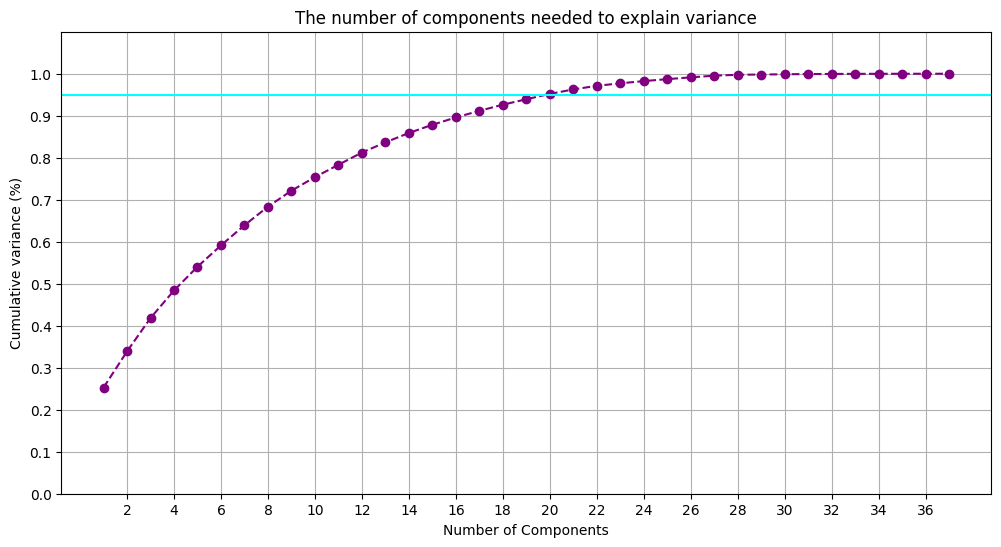

In [15]:
def plot_explained_variances(df):
    pca = PCA().fit(df)
    plt.rcParams["figure.figsize"] = (12,6)
    fig, ax = plt.subplots()
    plt.ylim(0.0,1.1)
    plt.plot([i+1 for i in range(df.shape[1])], np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--', color='purple')
    plt.axhline(y=0.95, color='cyan', linestyle='-')
    plt.xlabel('Number of Components')
    plt.xticks(np.arange(start=2, stop=df.shape[1] + 1, step=2))
    plt.ylabel('Cumulative variance (%)')
    plt.yticks(np.arange(start=0, stop=1.1, step=0.1))
    plt.title('The number of components needed to explain variance')
    plt.grid(True)
    plt.show()
plot_explained_variances(df=df)
numof_components = 20

PCA also helps to be able to visualize the dataset. We are asked to reduce the dimension of the dataset to a reasonable number of features (done using explained variance method). Additionally I'll do it for number of components 2 and 3 to visualize them later.

In [16]:
def reduce_dimensions(n, data):
    pca = PCA(n_components=n)
    reduced_features = pca.fit_transform(data)
    return reduced_features

dims = [2, 3, numof_components]
SAMPLE_SIZE = 10000
features = {n: pd.DataFrame(reduce_dimensions(n=n, data=df), columns=["PC"+str(i+1) for i in range(n)]) for n in dims}
sample_features = {n: features[n].sample(n=SAMPLE_SIZE, random_state=17).reset_index(drop=True) for n in dims}

The dataset contains about *2e6* values. K-means 

*K-Means:*
- Space Complexity WCD: $ \mathcal{O} (N (D + k)) $
- Time Complexity WCD: Regardless of the time required to calculate the distance between two data points, Each iteration of the algorithm has a time complexity of $ \mathcal{O} (N K) $. Considering the number of iterations I, is $ \mathcal{O} (N K I) $

*DBscan:*
- Space Complexity WCD: $ \mathcal{O} (N^2) $
- Time Complexity WCD: $ \mathcal{O} (N^2) $

In conclusion k-means has linear complexity and DBscan has quadratic complexity. In order to find the best values we have to run each algorithm several times. DBscan has two hyperparameters. So GridSeaching or RandomSearching it would take a lot of time. We could use *sample features* instead of the whole dataset and save ourself some time. 

<a id="clustering"></a>
## Clustering
### K-Means
There is only one hyperparameter and that is *k*, the number of clusters. First of all it picks *k* distinct points from the data points. Then it groups the rest of the points based on their euclidian distance from those *k* points. Now for each cluster it calculates the mean of all points in it and repeat the clustering process again with new *k* points. After a few iterations the clustering won't change anymore and that is the final answer. Also k-means doesn't identify any point as noise (based).

### DBSCAN
It is a density-based clustering algorithm designed to identify clusters of arbitrary shapes in a dataset. Let's describe the algorithm. There are two hyperparameters. *R* which is the radious of adjacency circle and *N* which is the minimum number of adjacents for each point to be count as a core point. First of all it identifies core points by simply drawing a circle around each point and count the number of points in it. After that it randomly selects a core point and starts to form a new cluster based on the core point. It adds all the close core points to the cluster. Then all the core points close to them and so on. When there is no more core points to add, It adds all the non-core points which was close to the core points to the cluster. It repeats the same process to identify the rest of the clusters as well. At the end there might be some unmarked points and those are the noisy points.

#### Comparison of two algorithms
K-means is more efficient for large datasets and is simpler to understand and implement. unlike k-means, DBSCAN is not sensitive to outliers. Unlike K-Means, DBSCAN does not assume clusters to be spherical and can discover clusters with varying shapes and sizes

<a id="optimal k"></a>
### Finding optimal *k* to use in k-means algorithm
There are different methods to find the best k. Here we used elbow method and silhouette score.
- Elbow method calculates the sum of squared distances between data points and their nearest cluster centroid, known as the Within-Cluster Sum-of-Squares (WCSS) for different k values.

Finished working on dim 2 plot.
Finished working on dim 3 plot.
Finished working on dim 20 plot.


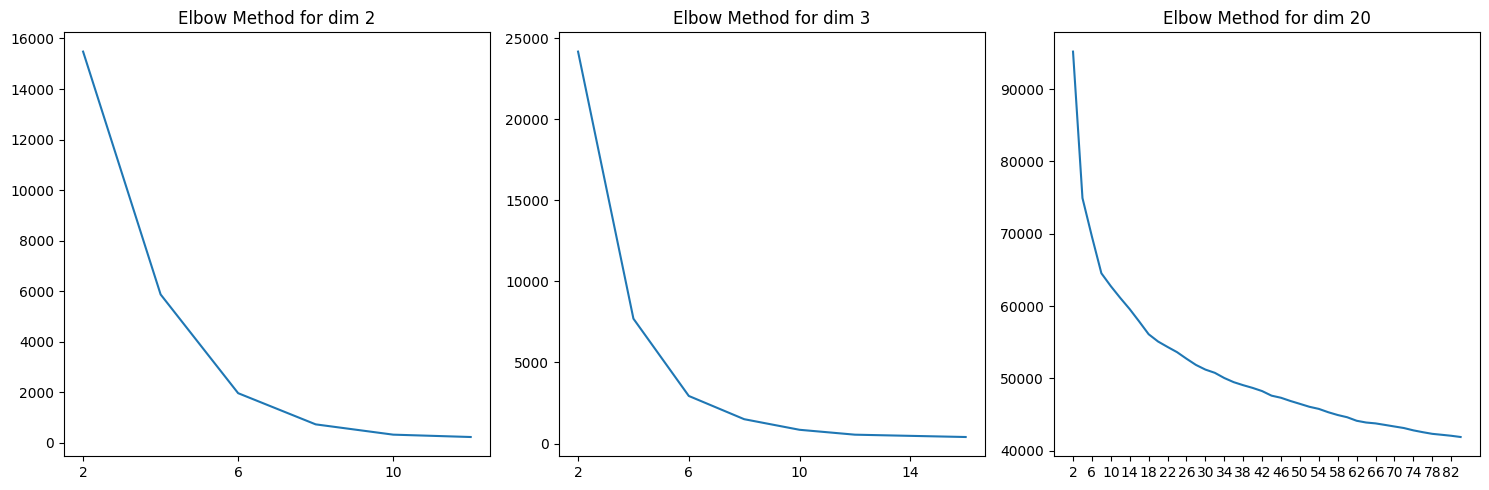

In [17]:
def run_tests_to_find_optimal_k(rng, features, dim):
    inertia = []
    for k in rng:
        print(f"working on model with k = {k}", end="\r")
        kmeans_model = KMeans(n_clusters=k, random_state=17)
        kmeans_model.fit(X=features)
        inertia.append(kmeans_model.inertia_)
    print(f"Finished working on dim {dim} plot.")

    return inertia

def draw_graph_k(dims, features):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
    for i in range(len(dims)):
        rng = range(2, 4 * dims[i] + 5, 2)
        scores = run_tests_to_find_optimal_k(rng=rng, features=features[dims[i]], dim=dims[i]) 
        axes[i].set_title(f"Elbow Method for dim {dims[i]}")
        axes[i].plot(rng, scores)
        axes[i].set_xticks(range(2, 4 * dims[i] + 5, 4))
    plt.tight_layout()
    plt.show()

draw_graph_k(dims=dims, features=features)

Obviously the higher the number of clusters, the less the WCSS gets. But we don't want that. what we want is a reasonable number of clusters with both good accuracy and efficiency.

<a id="optimal epsilon"></a>
### Finding optimal $ \epsilon $ and min samples to use in DBscan
- *Min Samples:* I didn't find any specific way for it. I just tested different values and chose the best ones.
- *Epsilon:* In a clustering with MinPts = k, we expect that core pints and border points’ distance from their k'th nearest neighbor be within a certain range (around the optimal $ \epsilon $), while noise points can have much greater value. First we'll plot this value in ascending order, and look for a significant "knee" or a sharp change in slope. The point corresponding to this change can be chosen as the eps value.

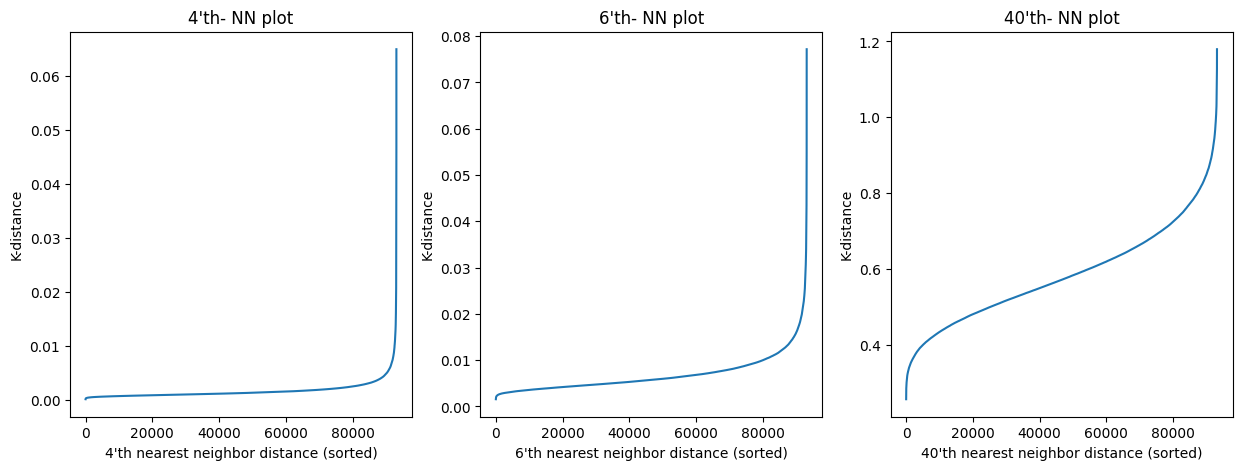

In [18]:
def find_optimal_eps(features, min_samples):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    for i in range(len(features)):
        k = min_samples[i]
        nbrs = NearestNeighbors(n_neighbors=k, algorithm='kd_tree').fit(features[i])
        distances, indices = nbrs.kneighbors(return_distance=True)
        ax[i].plot(np.sort(distances[:, k-1]))
        ax[i].set_xlabel(f'{k}\'th nearest neighbor distance (sorted)')
        ax[i].set_ylabel('K-distance')
        ax[i].set_title(f'{k}\'th- NN plot')
    plt.show()

find_optimal_eps([features[i] for i in dims], [dim*2 for dim in dims])

<a id="train model"></a>
## Training models

Here is the code to train models.

In [19]:
def train_k_mean_model(k, features):
    kmeans_model = KMeans(n_clusters=k, random_state=17).fit(X=features)
    labels = kmeans_model.labels_
    return kmeans_model, labels

def train_DBSCAN_model(eps, min_samples, features):
    dbscan_model = DBSCAN(eps=eps, min_samples=min_samples).fit(X=features)
    labels = dbscan_model.labels_
    return dbscan_model, labels

labels_k, labels_db = dict(), dict()
kmean_model, dbscan_model = dict(), dict()

Here I defined the hyperparameters values for each of the three number of components based on the explained methods.

In [35]:
k = {2:9, 3:9, numof_components:2}
eps = {2:0.02, 3:0.2, numof_components:0.8}
min_samples = {2:4, 3:6, numof_components:30}


In [36]:
kmean_model[2], labels_k[2] = train_k_mean_model(k=k[2], features=features[2])

In [37]:
kmean_model[3], labels_k[3] = train_k_mean_model(k=k[3], features=features[3])

In [23]:
kmean_model[numof_components], labels_k[numof_components] = train_k_mean_model(k=k[numof_components], features=features[numof_components])

In [33]:
dbscan_model[2], labels_db[2] = train_DBSCAN_model(eps=eps[2], min_samples=min_samples[2], features=features[2])

In [25]:
dbscan_model[3], labels_db[3] = train_DBSCAN_model(eps=eps[3], min_samples=min_samples[3], features=features[3])

In [26]:
dbscan_model[numof_components], labels_db[numof_components] = train_DBSCAN_model(eps=eps[numof_components],
                                        min_samples=min_samples[numof_components], features=features[numof_components])

<a id="visualization"></a>
## Visualazing Clusters

In [27]:
def draw_scatter_plot_2D(titles, features, pred_labels):
    pred_labels[1] += 1
    pred_labels[0] += 1
    labels_df = pd.DataFrame({titles[0]: pred_labels[0], titles[1]: pred_labels[1]})
    labels_df['PCA1'] = features["PC1"]
    labels_df['PCA2'] = features["PC2"]
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    for i in range(2):
        for cluster in list(np.unique(pred_labels[i])):
            cluster_data = labels_df[labels_df[titles[i]] == cluster]
            
            ax[i].scatter(cluster_data['PCA1'], cluster_data['PCA2'], label= "outlier" if cluster == 0 else f'cluster {cluster}')
        ax[i].set_title(titles[i])
    plt.tight_layout()
    plt.show()

def draw_scatter_plot_3D(title, pred_label, features):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(features["PC1"], features["PC2"], features["PC3"], c=pred_label, cmap='viridis')
    ax.set_title(title)
    plt.show()

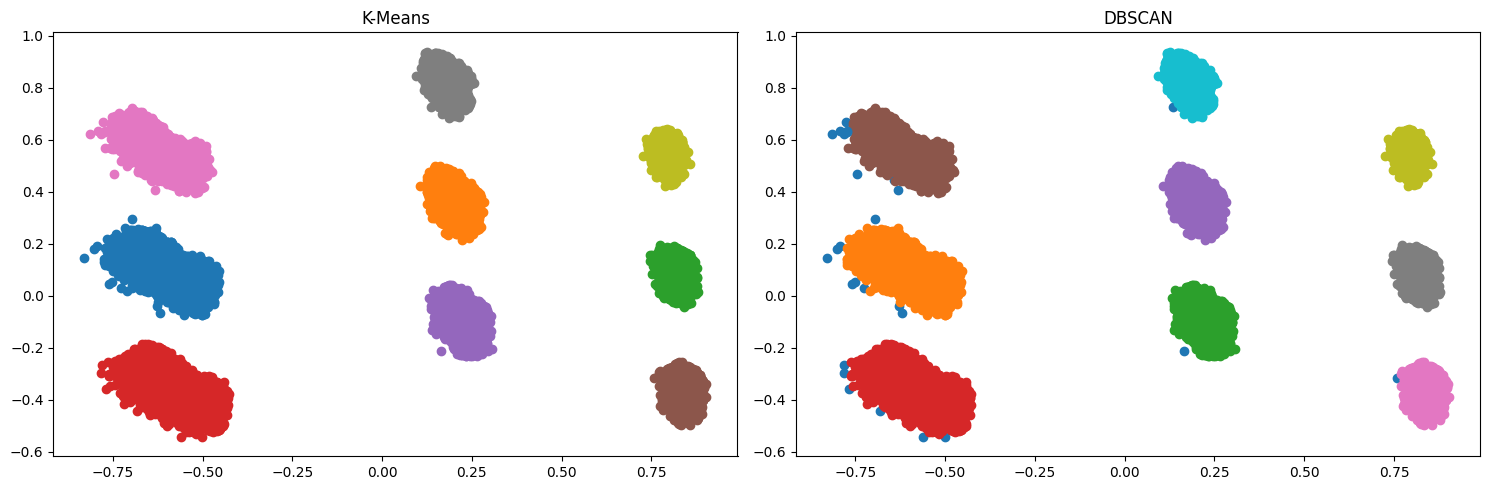

In [38]:
draw_scatter_plot_2D(titles=["K-Means", "DBSCAN"],
                     features=features[2], pred_labels=[labels_k[2], labels_db[2]])

The blue data points in Dbscan plot are considered as noisy points.

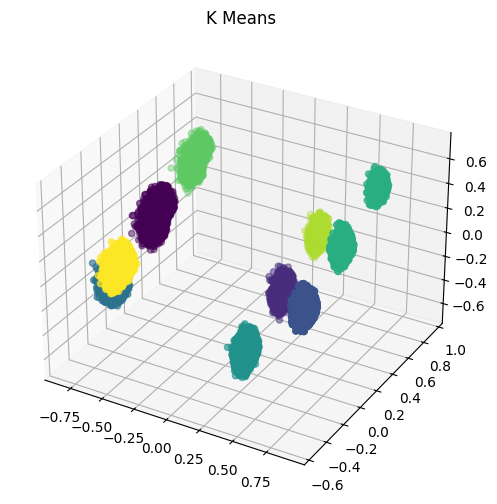

In [40]:
draw_scatter_plot_3D(title="K Means", pred_label=labels_k[3], features=features[3])

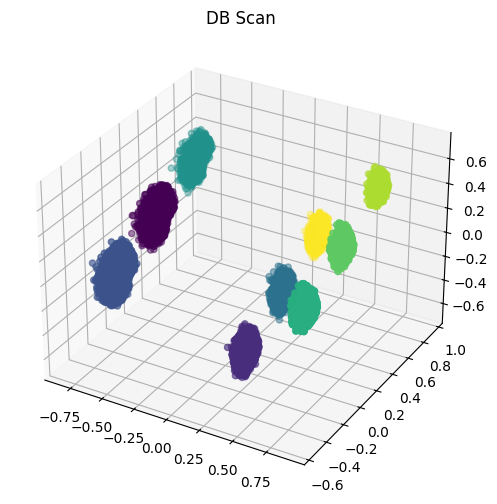

In [30]:
draw_scatter_plot_3D(title="DB Scan", pred_label=labels_db[3], features=features[3])

<a id="evaluation"></a>
## Evaluating the models

### Silhouette score
It is a measure of how similar an object is to its own cluster compared to other clusters. It ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. 
To calculate the solouhette score, First we have to calculate the silouhette coefficient for each data point as foolows:

$$ A_i = \frac{1}{N_c} \times \sum_{j=1}^{N_c} {dis(P_i, P_j)} \quad \quad B_i = \frac{1}{N_n} \times \sum_{j=1}^{N_n} {dis(P_i, P_j)} \quad \to \quad S_i = \frac {B_i - A_i} {max(A_i, B_i)}  $$

where *c* is the cluster the point is in and *n* is the nearest neighbor cluster to the point.

The silhouette score is the mean silhouette coefficient for all data points.

$$ \text{Silhouette Score} = \frac{1}{N} \sum_{i=1}^{N} {S_i} $$

#### outliers affection on score
The silhouette coefficient for outliers is probably a negative number. I thought they would have a negative impact on the mean. So i also calculated the sihouette score without considering the outliers. The result was not much better as I expected it to be. It's probably because of the small proportion of outliers compare to cluster points.  

In [54]:
def calc_silhouette(X, labels, remove_outliers=False):
    if remove_outliers:
        X["label"] = labels
        X = X[X["label"] != -1].reset_index(drop=True)
        labels = X["label"].tolist()
        X.drop("label", axis=1, inplace=True)
    return silhouette_score(X=X, labels=labels)

After tsting algorithms with different values of hyperparameters, The best results of each clustering algorithm is stored in a csv file.

In [ ]:
best_dbscan_results = pd.read_csv("./dbscan.csv")
best_dbscan_results

,min samples,epsilon,clusters num,slhouette score
0,20,0.8,87,32.6
1,30,0.8,77,33.5
2,10,0.6,80,23.5
3,5,0.7,115,28.4
4,7,0.8,100,30.0


In [41]:
best_kmeans_results = pd.read_csv("./kmeans.csv")
best_kmeans_results

,k,silhouette score
0,2,36.2
1,4,25.2
2,6,12.0
3,8,15.3
4,10,14.9
5,12,10.0
6,15,8.6
7,20,7.6


In [42]:
for k in best_kmeans_results["k"]:
    model, preds = train_k_mean_model(k=k, features=features[numof_components])
    display(pd.DataFrame(np.unique(preds, return_counts=True),
            index=["bruh", "count"], columns=[f"cluster {i}" for i in np.unique(preds)]).drop("bruh", axis=0))

,cluster 0,cluster 1
count,71107,22043


,cluster 0,cluster 1,cluster 2,cluster 3
count,30254,22043,29492,11361


,cluster 0,cluster 1,cluster 2,cluster 3,cluster 4,cluster 5
count,19433,8845,29492,7737,14445,13198


,cluster 0,cluster 1,cluster 2,cluster 3,cluster 4,cluster 5,cluster 6,cluster 7
count,10469,15702,8845,13198,14036,11557,5553,13790


,cluster 0,cluster 1,cluster 2,cluster 3,cluster 4,cluster 5,cluster 6,cluster 7,cluster 8,cluster 9
count,10468,7118,8845,13198,14032,11562,5553,12123,2333,7918


,cluster 0,cluster 1,cluster 2,cluster 3,cluster 4,cluster 5,cluster 6,cluster 7,cluster 8,cluster 9,cluster 10,cluster 11
count,10468,7100,7577,5740,14032,11562,5553,12114,2328,7950,5481,3245


,cluster 0,cluster 1,cluster 2,cluster 3,cluster 4,cluster 5,cluster 6,cluster 7,cluster 8,cluster 9,cluster 10,cluster 11,cluster 12,cluster 13,cluster 14
count,10488,6067,7074,5026,8639,8202,4921,4049,2231,6555,5289,1729,9365,2925,10590


,cluster 0,cluster 1,cluster 2,cluster 3,cluster 4,cluster 5,cluster 6,cluster 7,cluster 8,cluster 9,cluster 10,cluster 11,cluster 12,cluster 13,cluster 14,cluster 15,cluster 16,cluster 17,cluster 18,cluster 19
count,7093,5692,7072,5021,4562,5136,4064,6129,1969,5724,5294,1729,2735,2927,4818,4132,1738,4121,3422,9772


In [43]:
def save_result(label_k, label_db):
    result_df = pd.DataFrame()
    result_df["kmean_label"] = label_k
    result_df["dbscan_label"] = label_db

    result_df.to_csv('results.csv', index=False)

save_result(label_k=labels_k[numof_components], label_db=labels_db[numof_components])

### Evaluating models of two and three dimension

In [55]:
res = [{"K Means Silhouette Score": round(calc_silhouette(X=features[n], labels=labels_k[n]), 3),
           "DB scan Silhouette Score": round(calc_silhouette(X=features[n], labels=labels_db[n]), 3)} for n in [2, 3]]
pd.DataFrame(data=res, index=["2 dim", "3 dim"])

,K Means Silhouette Score,DB scan Silhouette Score
2 dim,0.824,0.802
3 dim,0.698,0.749


## Questions
Preprocessing steps and finding optimal hyperparameters are explained [here](#preprocessing), [here](#finding-optimal-k-to-use-in-k-means-algorithm), [here](#finding-optimal-and-min-samples-to-use-in-dbscan) and [here](#finding-an-optimal-numof-components)

### Removing unwanted data
I started with 101767 data points each one containing 50 feautres and ended up with 93150 data points and 37 features at the end of the preprocess. The reason for removing each colummn or row is explained. The reason for doing this is to have a more clean and meaningful dataset.
### Silhouette coefficients distribution
Here is the plot of silhouette coefficients over all the data points:

In [48]:
def plot_silhouette_coefs(sil_coefs):
    sorted_coefs = np.sort(sil_coefs)
    plt.plot(sorted_coefs)
    plt.xlabel("Data Points")
    plt.ylabel("Correlation Coefficient")
    plt.title("Correlation coefficient of all data points in ascending order")

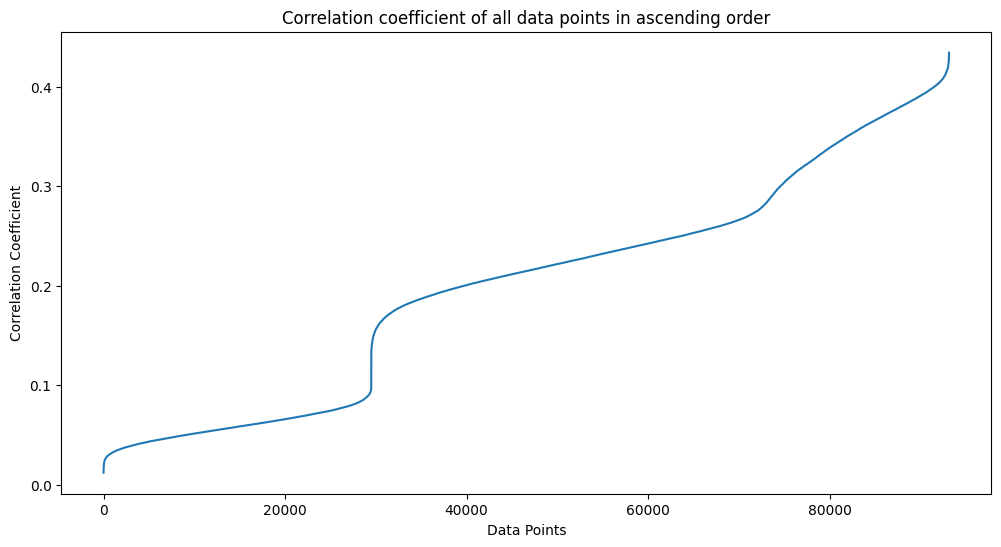

In [49]:
k_silhouette_coefficients = silhouette_samples(X=df, labels=labels_k[numof_components])
plot_silhouette_coefs(sil_coefs=k_silhouette_coefficients)

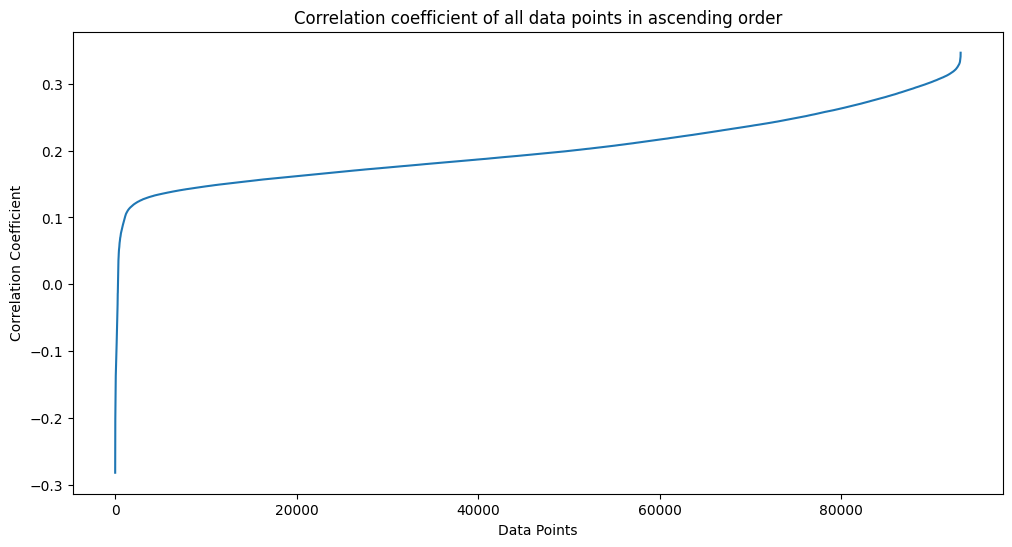

In [51]:
db_silhouette_coefficients = silhouette_samples(X=df, labels=labels_db[numof_components])
plot_silhouette_coefs(sil_coefs=db_silhouette_coefficients)

### Choosing the Optimal Clustering Method
These factors are important to us and we'll choose the algorithm considering all of them.
- *Expected shape of clusters:* K-Means if they are expected to have spherical shape and DBscan in case of irregular shapes.
- *Number of clusters:* If this number is predictable, use K-Means.
- *Outliers:* DBscan if the dataset contains outliers and K-Means of not.
- *Computational efficiency:* If it is a concern, K-Means would be a better option.

## References
Provided [Dataset](https://www.hindawi.com/journals/bmri/2014/781670/)

Dr Fadaei's AI course

outlier detection: [isolation forest](https://www.geeksforgeeks.org/what-is-isolation-forest/)

finding optimal hyperparameters: [k](https://www.geeksforgeeks.org/ml-determine-the-optimal-value-of-k-in-k-means-clustering/), [$ \epsilon $](http://www.sefidian.com/2022/12/18/how-to-determine-epsilon-and-minpts-parameters-of-dbscan-clustering/), [numof components](https://mikulskibartosz.name/pca-how-to-choose-the-number-of-components)